In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from joblib import dump
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    make_scorer,
    confusion_matrix,
    accuracy_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')


# Desarrollo de un modelo predictivo sobre fraude en transacciones basadas en el uso de tarjetas de crédito

El núcleo del trabajo es el desarrollo de un modelo predictivo sobre datos de transacciones bancarias con tarjetas de crédito para detectar cuantas transacciones han sido fraudulentas. El _dataset_ de trabajo esta altamente desbalanceado, con lo que es necesario el desarrollo de técnicas de preparación previas al desarrollo del modelo. El proyecto se basa en la iniciativa de [Kaggle](https://www.kaggle.com/) desde donde se puede acceder al _dataset_.



## Contenidos

* [1. Carga de los datos](#chapter1)
    * [1.1 Comprobación de la carga de los datos](#section_1_1)
    * [1.2 Búsqueda de valores nulos](#section_1_2)
* [2. Análisis descriptivo](#chapter2)
    * [2.1 Resumen del juego de datos](#section_2_1)
    * [2.2 Preprocesamiento de datos](#section_2_2)
    * [2.2 Balance de la muestra](#section_2_2)
    * [2.3 Distribución de Time y Amount](#section_2_3)
    * [2.4 Conclusiones del análisis](#section_2_4)
* [3. Normalización de Amount y Time](#chapter3)
* [4. Particionado de los datos](#chapter4)
* [5. Creación de muestras balanceadas](#chapter5)
    * [5.1 Selección de algoritmos undersampling](#section_5_1)
    * [5.2 Selección de algoritmos oversampling](#section_5_2)
    * [5.3 Correlaciones](#section_5_3)
        * [5.3.1 Conclusiones](#section_5_3_1)
* [6. Selección de clasificadores](#chapter6)
    * [6.1 KNN, LogisticRegression y Decision Tree](#section_6_1)
    * [6.2 Isolation Forest](#section_6_2)
    * [6.3 Conclusiones](#section_6_3)
* [7. Entrenamiento de modelos](#chapter7)
    * [7.1 KNN, LogisticRegression y Decision Tree](#section_7_1)
    * [7.2 Isolation Forest](#section_7_2)
    * [7.3 Búsqueda de hiperparámetros y cross validation](#section_7_3)
        * [7.3.1  KNN, LogisticRegression y Decision Tree](#section_7_3_1)
        * [7.3.2  Isolation Forest](#section_7_3_2)
        * [7.3.3 Métricas y matrices de confusión](#section_7_3_3)
* [8. Persistencia de modelos](#chapter8)
    * [8.1 Tamaño en memoria](#section_8_1)
    * [8.2 Precisión](#section_8_2)
* [9. Interpretación de los resultados](#chapter9)
    * [9.1 Logistic Regression + ROS](#section_9_1)
    * [9.2 K-Nearest Neighbors + ROS](#section_9_2)
    * [9.3 Resto de clasificadores](#section_9_3)



## 1. Carga de los datos <a class="anchor" id="chapter1"></a>

La información que se ha proporcionado para la elaboración de este trabajo ha sido supervisada y validada por los expertos en el dominio del negocio. Estos datos han sido procesados mediante técnicas de reducción de dimensionalidad [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) y se encuentren normalizados. Los valores de las columnas se encuentran anonimizados. Para la creación de este informe se ha proporcionado un fichero con extensión `csv` que contiene todos los datos que se van a utilizar.

En otros escenarios tendríamos que utilizar algún tipo de conexión a una base de datos o utilizar tecnologías de procesamiento de datos masivos pero en este caso basta con realizar una carga simple del fichero: `creditcard.csv`. En caso de pérdida es posible descargar una copia desde [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) o directamente desde el [siguiente](https://drive.google.com/file/d/1TmAYpjQOCDJ5_rluO737rQSWoUD1qkj5/view?usp=sharing) enlace. Una vez descargado basta con descomprimir el fichero y extraer el contenido en el directorio raíz desde donde se va a ejecutar este _notebook_.


In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Comprobación de la carga de los datos <a class="anchor" id="section_1_1"></a>

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


El juego de datos se ha cargado correctamente y los nombres de las columnas son los que originalmente hemos observado en el fichero de entrada original.


### 1.2 Búsqueda de valores nulos <a class="anchor" id="section_1_2"></a>

In [4]:
print(f'Null values: {df.isnull().sum().max()}')

Null values: 0



El resultado anterior nos indica que no existen valores nulos en el juego de datos por lo que no será necesario realizar ningún preprocesamiento para compensarlo.



## 2. Análisis descriptivo <a class="anchor" id="chapter2"></a>

En este apartado del informe procederemos a realizar un análisis de la calidad de los datos de entrada. El objetivo de este estudio será extraer todo el conocimiento posible de la información para así poder aplicar técnicas que mejoren su calidad o detectar posibles anomalías que puedan hacer que la eficiencia del modelo final se vea afectada.


### 2.1 Resumen del juego de datos <a class="anchor" id="section_2_1"></a>

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



Analizando la tabla anterior podemos comprobar que la suposición inicial, es decir, que las columnas con valores anónimos se encuentran escaladas es cierta. Vemos que el resto de columnas que no representan la clase (**Amount** y **Time**) no han sido procesadas.


### 2.2 Balance de la muestra <a class="anchor" id="section_2_2"></a>

<AxesSubplot:xlabel='Class', ylabel='count'>

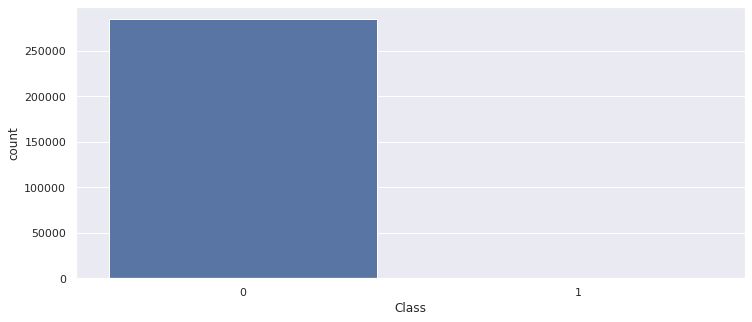

In [6]:
sns.set(rc={
    'figure.figsize': (12, 5)
})
sns.countplot(x='Class', data=df)

In [7]:
ROUND_PERCENT = 3

def get_dataset_info(dataframe, prec=ROUND_PERCENT):
    legit_count, fraud_count = dataframe['Class'].value_counts()
    total_count, total_cols = dataframe.shape
    info = {
        'legit transactions percent': f'{round((legit_count / total_count) * 100, prec)}%',
        'fraud transactions percent': f'{round((fraud_count / total_count) * 100, prec)}%',
        'total transactions': total_count,
        'total columns': total_cols,
        'total legit transactions count': legit_count,
        'total fraud transactions count': fraud_count,
    }

    return pd.DataFrame(info.values(), index=info.keys())


display(get_dataset_info(dataframe=df))

,0
legit transactions percent,99.827%
fraud transactions percent,0.173%
total transactions,284807
total columns,31
total legit transactions count,284315
total fraud transactions count,492



Podemos ver que, en efecto, el juego de datos original se encuentra muy desbalanceado. Para compensar este defecto tendremos que utilizar técnicas de balanceo de datos como _undersampling_ o _oversampling_ para que el modelo resultante tenga la máxima calidad posible.


### 2.3 Distribución de Time y Amount <a class="anchor" id="section_2_3"></a>

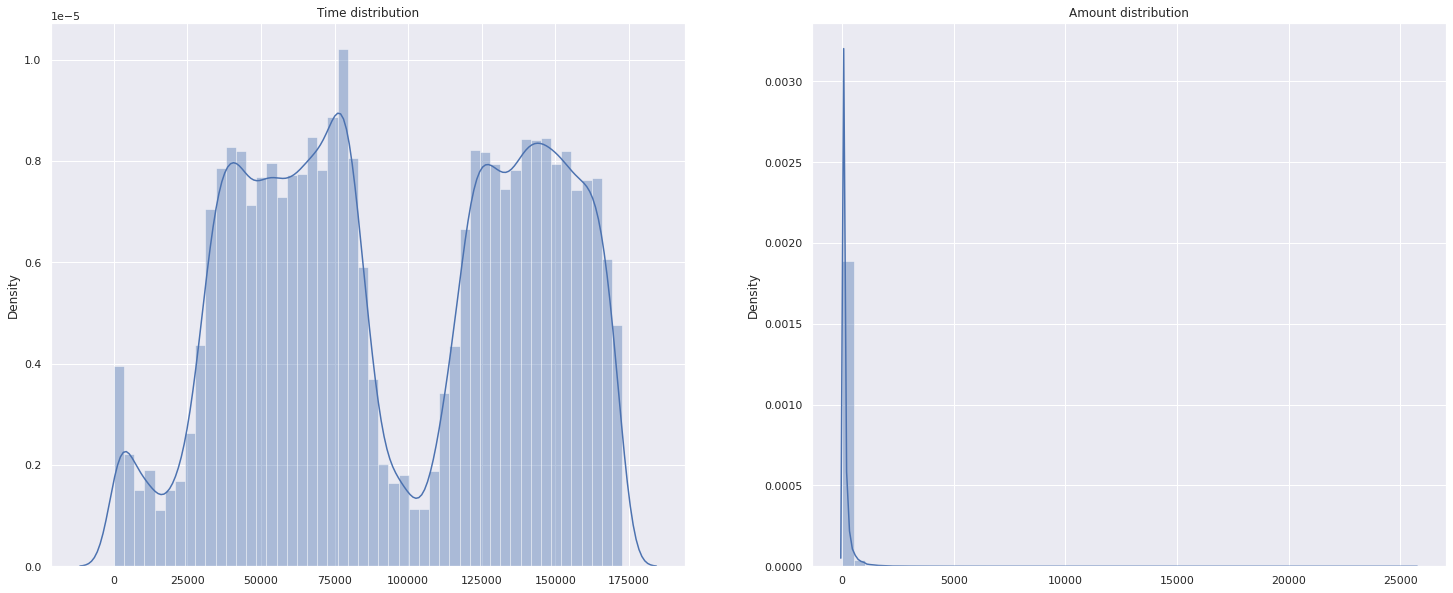

In [8]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25, 10)
)

for col, ax in zip(('Time', 'Amount'), axes.flat):
    ax.set_title(f'{col} distribution')
    sns.distplot(x=df[col], ax=ax)
plt.show()


### 2.4 Conclusiones del análisis <a class="anchor" id="section_2_4"></a>



De los apartados anteriores podemos extraer la siguientes conclusiones sobre los datos proporcionados:
 * El juego de datos se encuentra muy desbalanceado:
    * Transacciones legítimas: 284315
    * Transacciones fraudulentas: 492
    * Porcentaje de transacciones legítimas: 99.827%
    * Porcentaje de transacciones fraudulentas: 0.173%
 * Se puede considerar el tamaño total del juego de datos no es muy alto teniendo 284807 filas.
 * No existen valores nulos.
 * Tiene 31 columnas:
    * 28 columnas anonimizadas y normalizadas después de un proceso de PCA. Estas columnas tienen nombres que van desde **V1** a **V28**.
    * **Time**: tiempo transacurrido desde la primera transacción.
        * Debe de realizarse un proceso de normalización.
    * **Amount**: cantidad de la transacción en dólares (USD).
        * Como se puede apreciar en el gráfico _Amount distribution_ las cantidades son muy pequeñas.
        * Debe de realizarse un proceso de normalización.
    * **Class**: categoría de la transacción. Este valor está proporcionado por el juego de datos y es el que se intenta predecir.
        * Transacción legítima: 0
        * Transacción fraudulenta: 1
 * Debido al gran desbalanceo de los datos no se podrá utilizar _accuracy_ como métrica ya que podría llevarnos a resultados erróneos.
 * Hay que optimizar los modelos usando _f1-score_, _precision_ y _recall_
 * Las matrices de confusión nos mostrarán qué modelo resultante es el más eficiente.
 * La partición de los datos utilizará un 80% para entrenamiento y un 20% para pruebas.


## 3. Normalización de Amount y Time <a class="anchor" id="chapter3"></a>

Como hemos comentado en apartados anteriores las columnas **Amount** y **Time** no se encuentran normalizadas. Para conservar los datos de las columnas originales crearemos dos nuevas con los nombres _ScaledTime_ y _ScaledAmount_. Antes de realizar este proceso procederemos a analizar la distribución de ambas columas para ver qué cantidad de valores extremos o _outliers_ presenta y así elegir el mejor método de escalado.

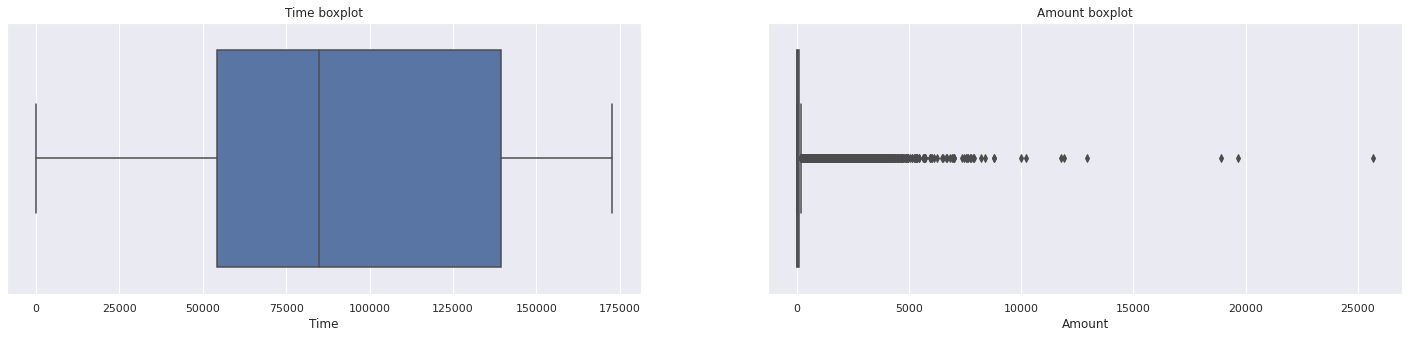

In [9]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25, 5)
)

for col, ax in zip(('Time', 'Amount'), axes.flat):
    ax.set_title(f'{col} boxplot')
    sns.boxplot(x=df[col], ax=ax)
plt.show()


La columna **Amount** parece que presenta algunos valores extremos en su distribución en las partes altas por lo que vamos a utilizar `RobustScaler` ya que hace que lso valores extremos no afecten tanto al proceso ya que utiliza la mediana y el rango intercuantil en vez de la media y la varianza.


In [10]:
robust_scaler = RobustScaler()

for scaled_col, original_col in zip(
        ('ScaledAmount', 'ScaledTime'),
        ('Amount', 'Time')):
    df[scaled_col] = robust_scaler.fit_transform(df[original_col].values.reshape(-1, 1))

df[['ScaledAmount', 'Amount', 'ScaledTime', 'Time', 'Class']].sample(10).head()

,ScaledAmount,Amount,ScaledTime,Time,Class
19500,-0.167680,10.00,-0.638659,30330.0,0
104931,-0.283658,1.70,-0.180911,69293.0,0
71256,-0.234612,5.21,-0.357875,54230.0,0
260008,0.574303,63.10,0.877278,159365.0,0
15935,0.894292,86.00,-0.673422,27371.0,0


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ScaledAmount,ScaledTime
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,0.927124,0.118914
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,3.495006,0.557903
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-0.307413,-0.994983
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-0.229162,-0.358210
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,0.770838,0.641790
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,358.683155,1.035022



En este punto el juego de datos tiene las columnas _ScaledAmount_ y _ScaledTime_. Para seguir con el siguiente paso del análisis se van a eliminar las columnas originales sin normalizar y renombraremos las normalizadas. A partir de aquí sólo trabajaremos con datos normalizados para todas las columnas salvo la de la clase.


In [12]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)
df.rename(
    columns={
        'ScaledAmount': 'Amount',
        'ScaledTime': 'Time'
    },
    inplace=True
)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960



## 4. Particionado de los datos <a class="anchor" id="chapter4"></a>

Antes de proceder a procesar la información con técnicas de balanceo hay que particionar los datos. Aunque estos datos también van a particionarse de la misma forma al generar los juegos de datos balanceados, las pruebas han de realizarse sobre el juego de datos original. El objetivo de este apartado es crear una partición del juego de datos original con datos de entrenamiento sobre los que poder aplicar _oversampling_ o _undersampling_ y unos datos de pruebas con los que podremos probar las predicciones de los modelos resultantes. Se va a utilizar una partición de los datos entrenamiento/pruebas de un 80% / 20%.


In [13]:
TEST_SIZE = 0.2
RANDOM_STATE = 1

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 5. Creación de muestras balanceadas <a class="anchor" id="chapter5"></a>

En este apartado se crearán las muestras balanceadas sobre el juego de datos original para tener un la misma cantidad de filas para todas las clases. En este caso para nivelar la cantidad de apariciones de la clase 0 (transacción legítima) o 1 (transacción fraudulenta). Hay que aplicar este tipo de técnias ya que de no hacerlo:
* **Correlaciones erróneas**: aunque la mayoría de las columnas se encuentran anonimizadas es interetante conocer las relaciones que existen entre estas.
* **Overfitting**: si se utilizan los datos tal y como se encuentran, es decir, sin compensar las clases se acabará obteniendo un modelo sobreentrenado con mucho sesgo que no podrá clasificar de la mejor forma en un entorno real.


### 5.1 Selección de algoritmos undersampling <a class="anchor" id="section_5_1"></a>

Este tipo de técnicas realiza un procesado de los datos de tal forma que balancea la muestra original teniendo en cuenta la clase menos representada. Esto significa que las clases más representadas verán reducida la cantidad de filas para adecuarse en número a las clases menos representadas. En concreto vamos a utilizar los siguientes algoritmos:

* Random undersampling
 * NearMiss

### 5.2 Selección de algoritmos oversampling <a class="anchor" id="section_5_2"></a>

Este tipo de técnicas realiza un procesado de los datos de tal forma que balancea la muestra original teniendo en cuenta la clase más representada representada. Esto significa que las clases menos representadas aumentarán la cantidad de filas para adecuarse en número a las clases más representadas. En concreto vamos a utilizar los siguientes algoritmos:

* Random oversampling
* ADASYN
* SMOTE

En este apartado probaremos todos los algoritmos seleccionamos para la generación de muestras. De esta forma podremos comprobar qué hace realmente cada uno de ellos y analizaremos el resultado comparándolo al juego de datos original.

In [14]:
RANDOM_N = 1

SAMPLERS = [
    ('Random Under Sampling', RandomUnderSampler, RANDOM_STATE, 'majority'),
    ('NearMiss', NearMiss, None, 'majority'),
    ('Random Over Sampling', RandomOverSampler, RANDOM_STATE, 'minority'),
    ('SMOTE', SMOTE, RANDOM_STATE, 'minority'),
    ('ADASYN', ADASYN, RANDOM_STATE, 'minority'),
]

# Save samplers data for visualizations
samplers_df = {}

def get_sampled_dataframe(sampler_instance, random_state, sampling_strategy):
    sampler = sampler_instance(
        random_state=random_state,
        sampling_strategy=sampling_strategy,
    ) if random_state is not None else sampler_instance(
        sampling_strategy=sampling_strategy
    )
    X_sampled, y_sampled = sampler.fit_resample(X, y)
    df_sampled = X_sampled
    df_sampled['Class'] = y_sampled

    return df_sampled


for sampler_name, sampler, random_state, sampling_strategy in SAMPLERS:
    df_sampled = get_sampled_dataframe(
        sampler_instance=sampler,
        random_state=random_state,
        sampling_strategy=sampling_strategy,
    )
    samplers_df.update({
        sampler_name: df_sampled
    })

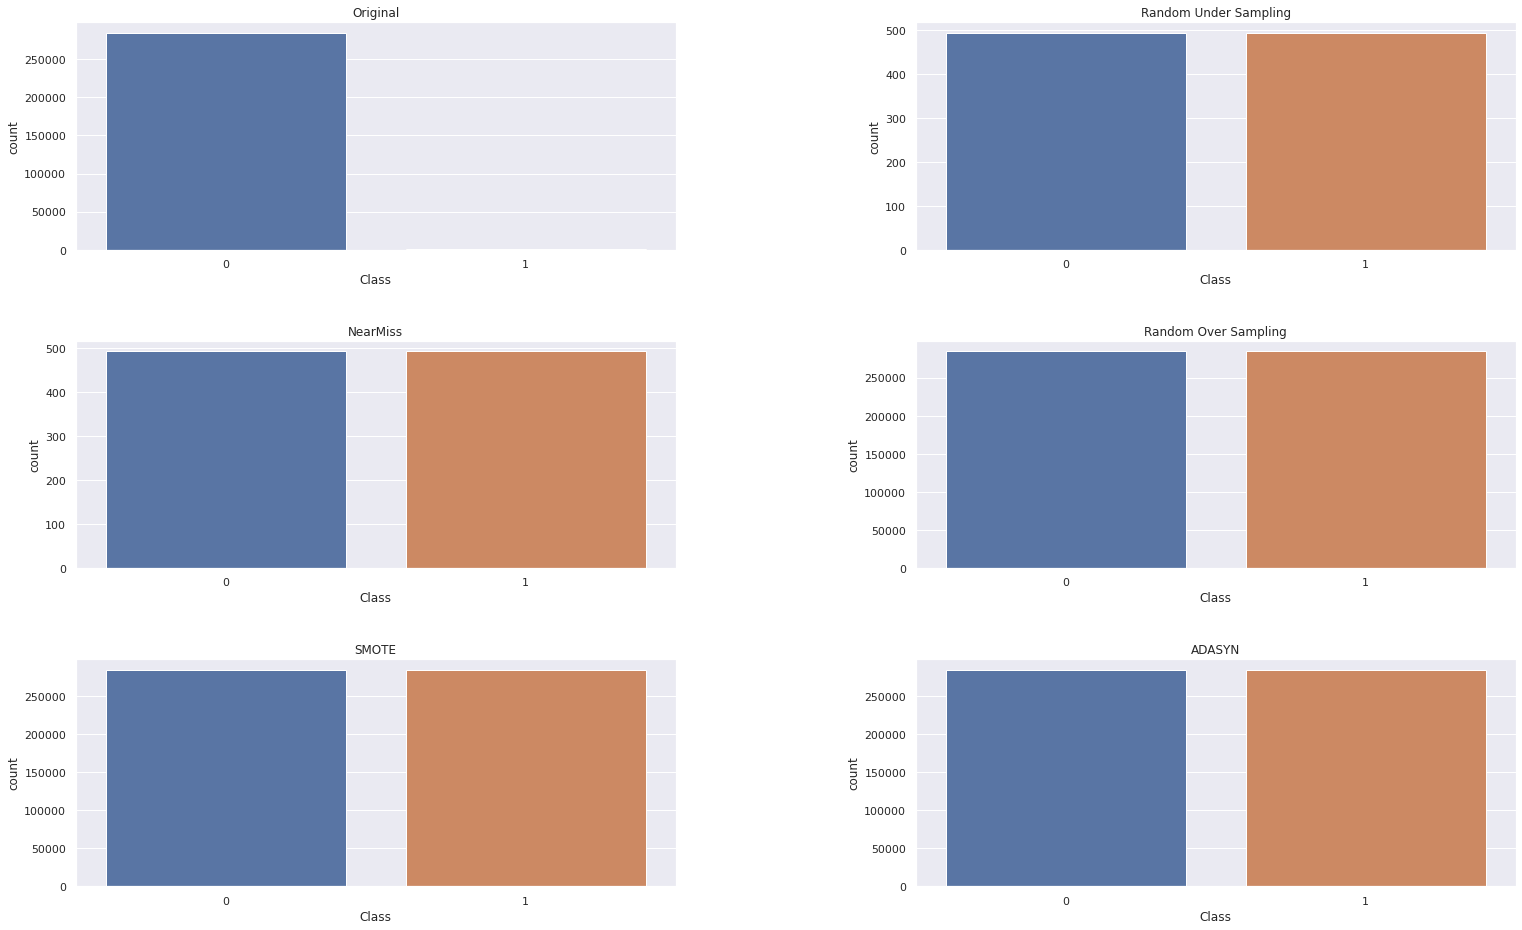

In [15]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(25, 15)
)

samplers_names = ['Original'] + list(samplers_df.keys())
samplers_data = [df] + list(samplers_df.values())

for col, dataframe, ax in zip(samplers_names, samplers_data, axes.flat):
    ax.set_title(f'{col}')
    sns.countplot(x='Class', ax=ax, data=dataframe)

plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.4,
    hspace=0.4,
)
plt.show()

Vemos que, efectivamente, los algoritmos que realizan _undersampling_ reducen la clase que más representación tiene para que tenga el mismo número que la infrarepresentada y los que aplican _oversampling_ realizan justo lo contrario: aumentan la muestra de la clase con menos filas para que se iguale a la que mayor número de filas tiene. A continuación vamos a visualizar las correlaciones de las variables para cada uno de ellos. De esta forma podremos obtener un mayor conocimiento del juego de datos y de cómo ha influído cada técnica en las correlaciones entre las diferentes columnas.

### 5.3 Correlaciones <a class="anchor" id="section_5_3"></a>

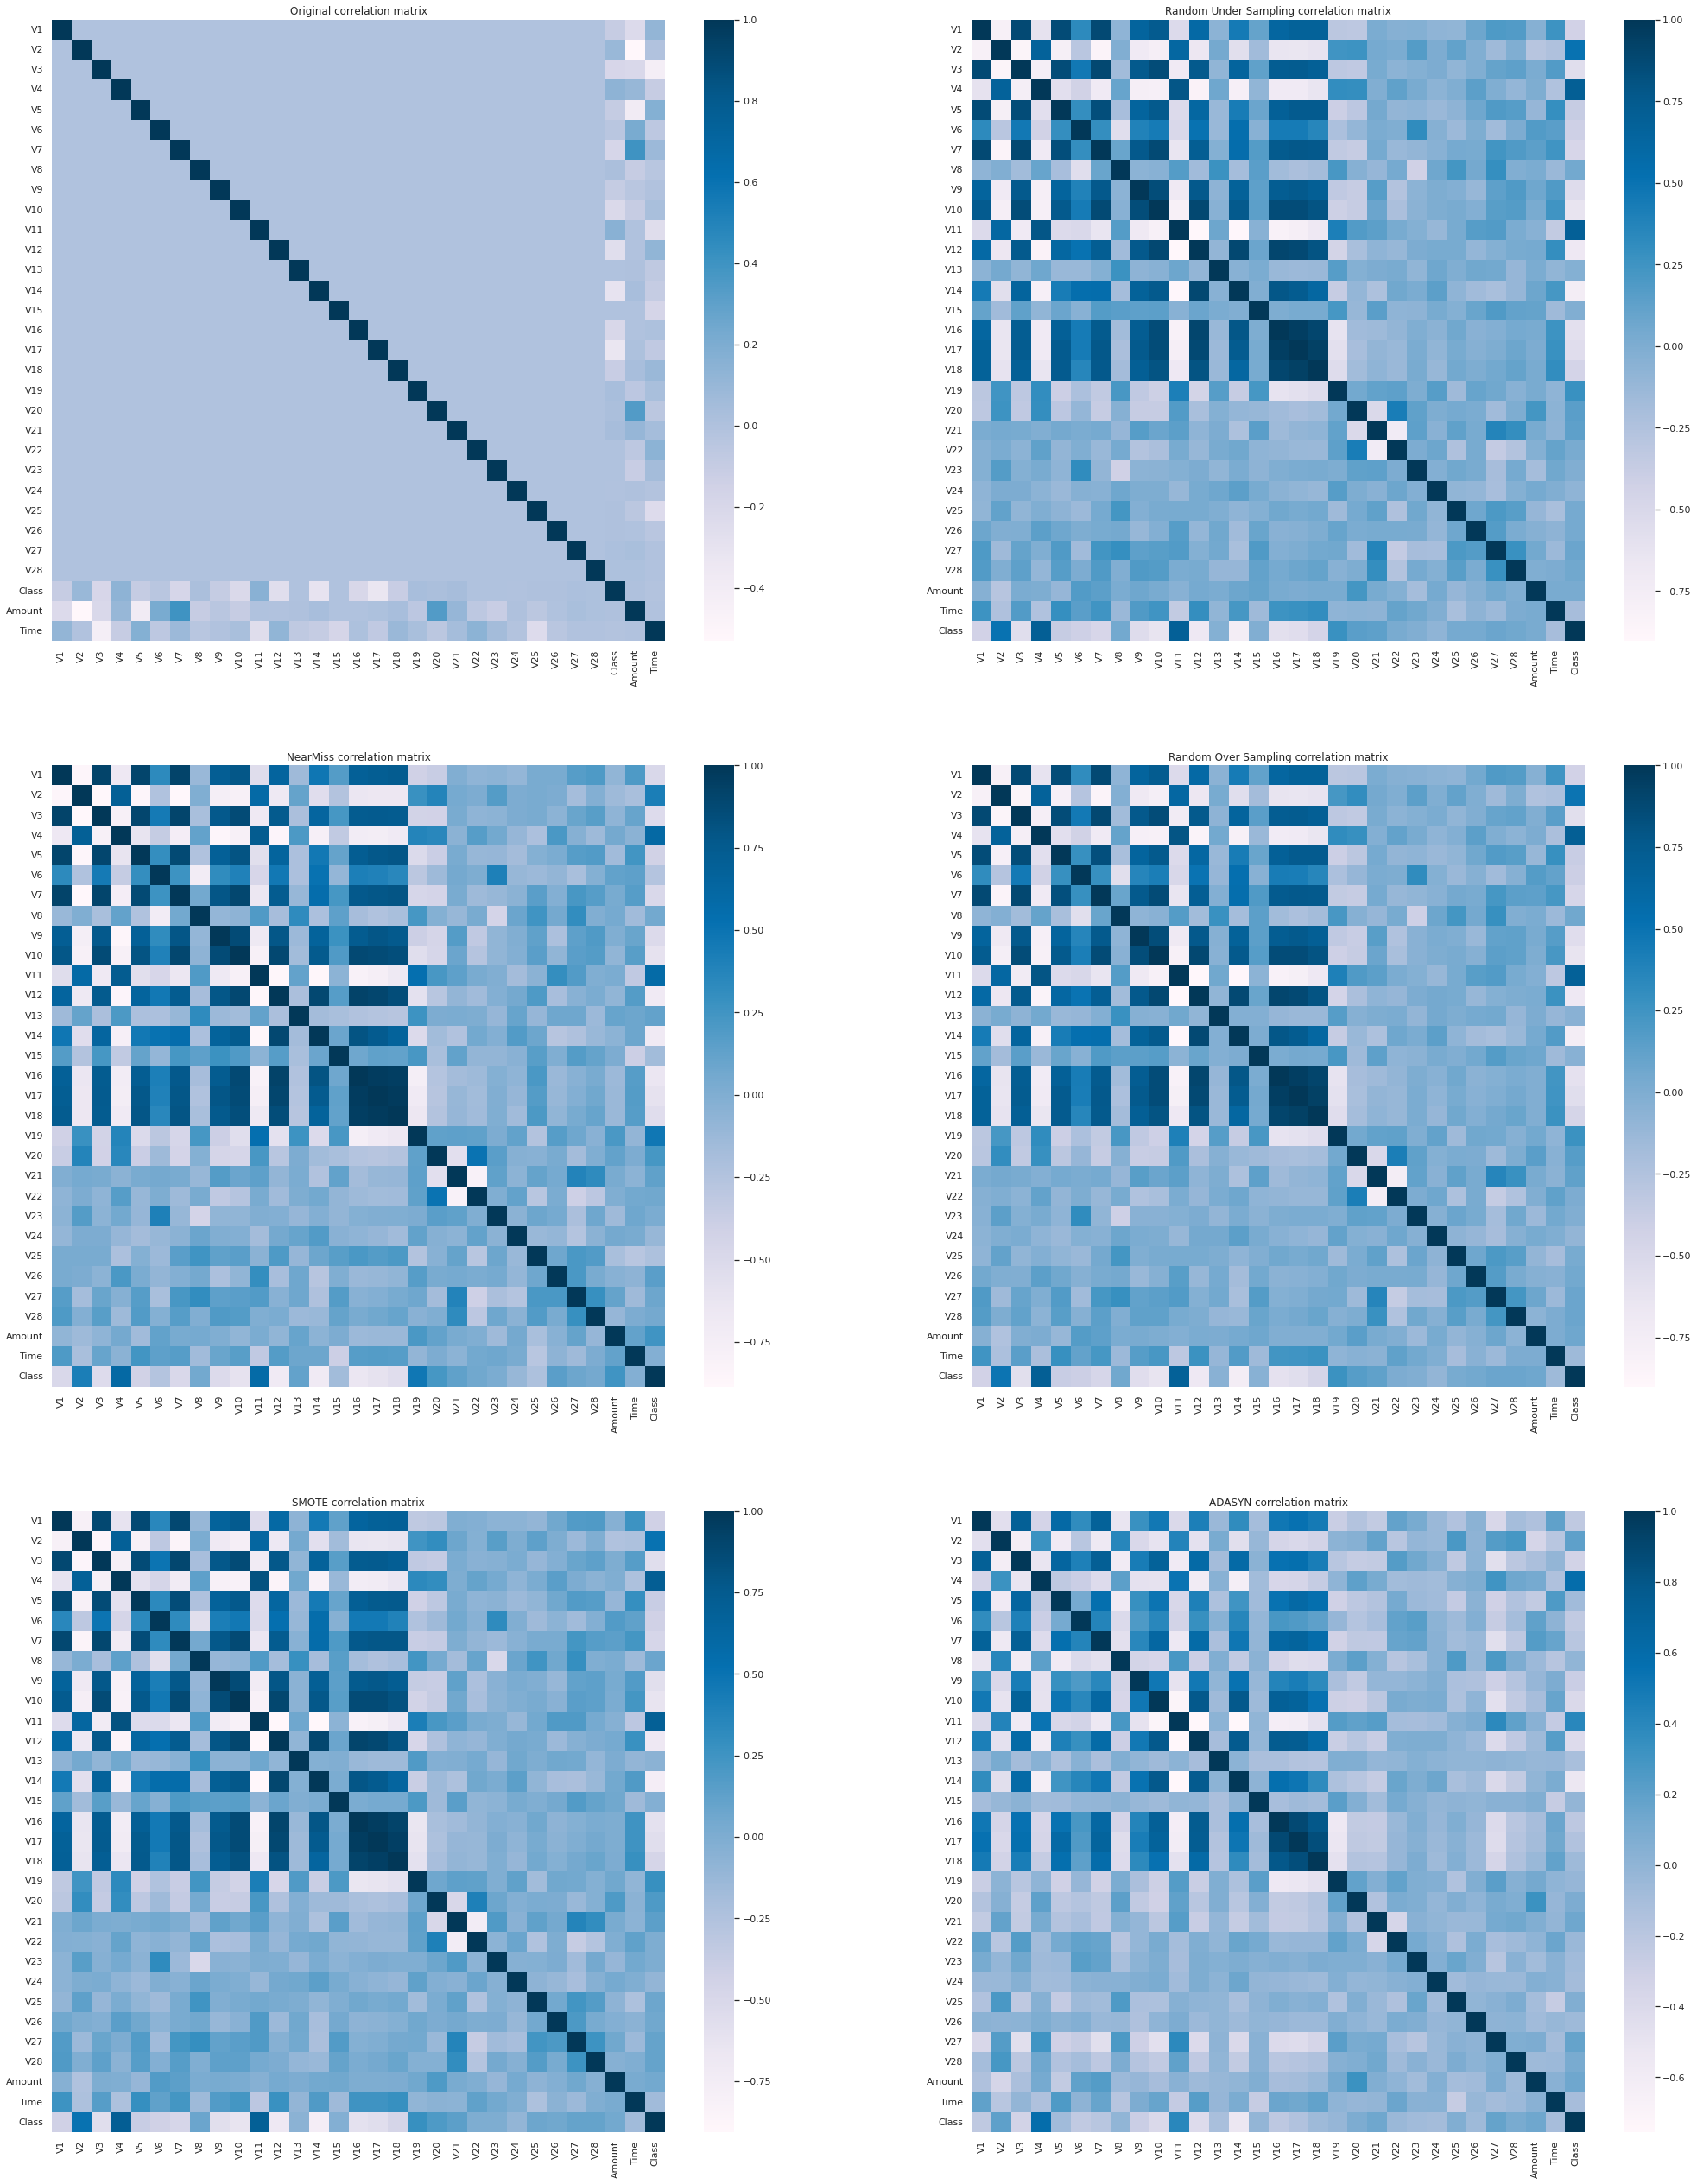

In [16]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(35, 45)
)

samplers_names = ['Original'] + list(samplers_df.keys())
samplers_data = [df] + list(samplers_df.values())

for col, dataframe, ax in zip(samplers_names, samplers_data, axes.flat):
    ax.set_title(f'{col} correlation matrix')
    sns.heatmap(data=dataframe.corr(), ax=ax, cmap='PuBu')

plt.show()

### 5.3.1 Conclusiones <a class="anchor" id="section_5_3_1"></a>


Observandos las matrices anteriores podemos obtener las siguientes conclusiones

* Correlación positiva: las columnas **V2**, **V4**, **V11** y **V19** están correlacionadas positivamente con el valor de la clase. Esto significa que cuanto mayor sean estos valores mayor probabilidad de que la transacción sea fraudulenta.
* Correlación negativa: las columnas **V10**, **V12**, **V14** y **V17** están correlacionadas negativamente con el valor de la clase. Esto significa que cuanto menor sean estos valores mayor probabilidad de que la transacción sea fraudulenta.


## 6. Selección de clasificadores <a class="anchor" id="chapter6"></a>

En este apartado se va a ejecutar un entrenamiento, sin ajuste de hiperparámetros, para cada uno de los modelos elegidos. Como en este punto ya tenemos el juego de datos original particionado crearemos un _pipeline_ que cree una muestra con cada uno de los algoritmos del apartado anterior y entrenaremos un clasificador. Los clasificadores que se han seleccionado para la elaboración de este trabajo son los siguientes:

* LogisticRegression.
* KNN.
* DecisionTree.
* IsolationForest.

Según se ha podido estudiar en la literatura existente cada uno de estos clasificadores puede resolver el problema que intentamos atajar, esto es, la clasificación correcta de transacciones fraudulentas de tarjetas de crédito en un juego de datos desbalanceado. Para cada uno de ellos mostraremos un reporte con el resultado de la clasificación. La finalidad de este apartado es seleccionar los mejores modelos y obtener los _baseline_ para, a partir de sus resultados, intentar optimizar sus hiperparámetros a posteriori.

## 6.1 KNN, LogisticRegression y Decision Tree <a class="anchor" id="section_6_1"></a>

In [17]:
def instantiate_clf(classifier_info):
    classifier_name, model, model_random_state, n_jobs, other = classifier_info

    model_instance = None

    if model_random_state is None and n_jobs is not None:
        model_instance = model(n_jobs=n_jobs)
    elif model_random_state is not None and n_jobs is not None:
        if classifier_name != 'Logistic Regression':
            model_instance = model(random_state=model_random_state, n_jobs=n_jobs)
        else:
            model_instance = model(random_state=model_random_state, n_jobs=n_jobs, max_iter=other)
    elif model_random_state is not None and n_jobs is None:
        model_instance = model(random_state=model_random_state)

    return classifier_name, model_instance

def instantiate_sampler(sampler_info):
    sampler_name, sampler, sampler_random_state, sampling_strategy = sampler_info

    sampler_instance = None

    sampler_instance = sampler(
        sampling_strategy=sampling_strategy
    ) if sampler_random_state is None else sampler(
        random_state=sampler_random_state,
        sampling_strategy=sampling_strategy
    )

    return sampler_name, sampler_instance

In [18]:
RANDOM_STATE = 1

CLASSIFIERS = [
    ('Logistic Regression', LogisticRegression, RANDOM_STATE, -1, 500),
    ('K-Nearest Neighbors', KNeighborsClassifier, None, -1, None),
    ('Decision Tree', DecisionTreeClassifier, RANDOM_STATE, None, None),
]

for classifier_info in CLASSIFIERS:
    for sampler_info in SAMPLERS:

        classifier_name, classifier_instance = instantiate_clf(classifier_info)
        sampler_name, sampler_instance = instantiate_sampler(sampler_info)

        pipeline = Pipeline([
            (sampler_name, sampler_instance),
            (classifier_name, classifier_instance),
        ])

        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f' === Classification report for {classifier_name} using {sampler_name} === ')
        print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

print('DONE')

 === Classification report for Logistic Regression using Random Under Sampling === 
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.98     56875
       Fraud       0.04      0.90      0.08        87

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962

 === Classification report for Logistic Regression using NearMiss === 
              precision    recall  f1-score   support

       Legit       1.00      0.55      0.71     56875
       Fraud       0.00      0.94      0.01        87

    accuracy                           0.55     56962
   macro avg       0.50      0.75      0.36     56962
weighted avg       1.00      0.55      0.71     56962

 === Classification report for Logistic Regression using Random Over Sampling === 
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56875


## 6.2 Isolation Forest <a class="anchor" id="section_6_2"></a>

Para el modelo _Isolation Forest_ el proceso que debe de realizarse es diferente. Este algoritmo sigue un funcionamiento distinto al del resto de algoritmos: es un algoritmo no supervisado que explícitamente aísla las anomaĺias y las etiqueta con una clase especial, en este caso, `-1` por lo que no podemos tratarlo como el resto de modelos del apartado anterior. Tampoco será necesario aplicar ningún algoritmo de balanceo de datos antes de entrenar el clasificador ya que está diseñado desde su base para juegos de datos desbalanceados. Como en la literatura que se ha consultado a la hora de hacer este informe se ha establecido que este tipo de clasificador puede dar buenos resultados en este apartado vamos a crear el modelo _baseline_ para este tipo de clasificador.


In [19]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])

model_isf = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1).fit(X_train)
y_pred = model_isf.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56875
       Fraud       0.19      0.20      0.19        87

    accuracy                           1.00     56962
   macro avg       0.59      0.60      0.60     56962
weighted avg       1.00      1.00      1.00     56962




## 6.3 Conclusiones <a class="anchor" id="section_6_3"></a>

Como resultado de los apartados [5](#chapter5), [6.1](#section_6_1) y [6.2](#section_6_2) se han seleccionado los siguientes _pipelines_ de proceso:

* K-Nearest Neighbors / Randon Over Sampling
* Decistion Tree / Random Over Sampling
* Logistic Regression / Random Over Sampling
* Isolation Forest



## 7. Entrenamiento de modelos <a class="anchor" id="chapter7"></a>

Una vez hemos seleccionado los modelos y las técnicas de balanceo de datos que vamos a utilizar en este apartado crearemos, para cada caso, tres modelos:
 * Un modelo sin datos balancedos. `(overfitted)`
 * Un modelo con datos balanceados aplicando los algoritmos del apartado anterior. `(Randon Over Sampler)`
 * Un modelo optimizado con datos balanceados. `(tuned)`

Se utilizarán las métricas que se seleccionaron en el apartado [2.4](#section_2_4) para comprobar cómo las técnicas de balanceo de datos pueden hacer que, en una situación en las que las clases del clasificador no están niveledas, se podrá generar un modelo que generalice de forma eficiente.



### 7.1  KNN, LogisticRegression y Decision Tree <a class="anchor" id="section_7_1"></a>


In [20]:
RANDOM_STATE = 1

def save_scores(y_test_data, y_pred_data, results, model_name):
    f1_score, precision, recall, _ = precision_recall_fscore_support(y_test_data, y_pred_data, average='macro')

    for label, value in zip(
            ('model', 'f1_score', 'precision', 'recall'),
            (model_name, f1_score, precision, recall),
    ):
        results[label].append(value)


SELECTED_CLASSIFIERS = [
    ('Logistic Regression', LogisticRegression, RANDOM_STATE, -1, 500),
    ('K-Nearest Neighbors', KNeighborsClassifier, None, -1, None),
    ('Decision Tree', DecisionTreeClassifier, RANDOM_STATE, None, None)
]

# Save model results for later visualizations
scores = {
    'model': [],
    'f1_score': [],
    'precision': [],
    'recall': [],
}

for classifier_info in SELECTED_CLASSIFIERS:
    classifier_name, classifier_instance = instantiate_clf(classifier_info)

    model = classifier_instance.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    save_scores(y_test, y_pred, scores, f'{classifier_name} (overfitted)')

    pipeline = Pipeline([
        ('Random Over Sampler', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy='minority')),
        (classifier_name, classifier_instance),
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    save_scores(y_test, y_pred, scores, f'{classifier_name} (Random Over Sampler)')

print('DONE')

DONE



### 7.2  Isolation Forest <a class="anchor" id="section_7_2"></a>


In [21]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])

model_isf = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1).fit(X_train)
y_pred = model_isf.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

save_scores(y_test, y_pred, scores, 'Isolation Forest')


### 7.3  Búsqueda de hiperparámetros y cross validation <a class="anchor" id="section_7_3"></a>

Una vez que hemos obtenido los resultados para los clasificadores (con y sin balanceo de datos) para todos los modelos vamos a ajustar los mejores hiperparámetros para afinar la eficiencia de los modelos. Como se ha explicado en apartados anteriores para juegos de datos no balanceados nos fijaremos en la métrica _f1-score_ por lo que la utilizaremos como función de ajuste. Una vez que obtengamos los mejores parámetros para cada modelo los entrenaremos y obtendremos sus resultados totales para poder compararlos entre sí.

En este apartado se ejecutará un _pipeline_ que realizará el balanceo de datos con los algoritmos seleccionados en apartados anteriores a la vez que realizamos _cross validation_ y ajuste de hiperparámetros.



### 7.3.1  KNN, LogisticRegression y Decision Tree <a class="anchor" id="section_7_3_1"></a>


In [22]:
N_SPLITS = 5
RANDOM_STATE = 1

f1_metric_scorer = make_scorer(f1_score, average='macro')
kf = StratifiedKFold(n_splits=N_SPLITS, random_state=None, shuffle=False)

# Save best models for later analysis
best_grid_models = {}

lr_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': list(np.logspace(-3, 3, 7)),
}

knn_param_grid = {
    'classifier__n_neighbors': [i for i in range(1, 6)],
}

dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [i for i in range(1, 11)],
    'classifier__min_samples_split': [i for i in range(1, 11)],
    'classifier__min_samples_leaf': [i for i in range(1, 6)],
}

for classifier_name, params, clf in zip(
        ('Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree'),
        (lr_param_grid, knn_param_grid, dt_param_grid),
        (LogisticRegression(max_iter=500), KNeighborsClassifier(), DecisionTreeClassifier())
):
    model = Pipeline([
        ('sampling', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy='minority')),
        ('classifier', clf)
    ])

    grid = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring=f1_metric_scorer, n_jobs=-1)
    grid_results = grid.fit(X=X_train, y=y_train)
    print(f'Best params for {classifier_name}: {grid_results.best_params_}')
    best_model = grid_results.best_estimator_

    y_pred = best_model.predict(X_test)
    save_scores(y_test, y_pred, scores, f'{classifier_name} (Random Over Sampling) (tuned)')
    best_grid_models.update({
        classifier_name: (best_model, y_pred)
    })

print('DONE')

Best params for Logistic Regression: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Best params for K-Nearest Neighbors: {'classifier__n_neighbors': 1}
Best params for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 9}
DONE



### 7.3.2  Isolation Forest <a class="anchor" id="section_7_3_2"></a>

Ajustaremos sus hiperparámetros para obtener la mejor versión del modelo y guardaremos los resultados para su posterior visualización y comparación con el resto de clasificadores que se han utilizado en el apartado [7.3.1](#section_7_3_1)


In [23]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])
if_param_grid = {
    'n_estimators': list(range(50, 200, 50)),
    'max_features': [1, 5, 10],
}

cv_isf_model = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1)
grid = GridSearchCV(estimator=cv_isf_model, param_grid=if_param_grid, cv=kf, scoring=f1_metric_scorer)
grid_results = grid.fit(X=X_train, y=y_train)
best_model = grid_results.best_estimator_
print(f'Best params for Isolation Forest: {grid_results.best_params_}')
y_pred = best_model.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

save_scores(y_test, y_pred, scores, 'Isolation Forest (tuned)')
best_grid_models.update({
    'Isolation Forest': (best_model, y_pred)
})

Best params for Isolation Forest: {'max_features': 5, 'n_estimators': 50}



### 7.3.3 Métricas y matrices de confusión <a class="anchor" id="section_7_3_3"></a>


In [24]:
df_scores = pd.DataFrame(scores)
df_scores.drop_duplicates('model', keep='first', inplace=True)
df_scores = df_scores.sort_values(by=['model'], ascending=False)
HTML(df_scores.to_html(index=False))

model,f1_score,precision,recall
Logistic Regression (overfitted),0.913450,0.775774,0.830819
Logistic Regression (Random Over Sampling) (tuned),0.537047,0.928456,0.564223
Logistic Regression (Random Over Sampler),0.534347,0.933377,0.559238
K-Nearest Neighbors (overfitted),0.949056,0.856260,0.897295
K-Nearest Neighbors (Random Over Sampling) (tuned),0.917537,0.879196,0.897441
K-Nearest Neighbors (Random Over Sampler),0.834793,0.896253,0.862929
Isolation Forest (tuned),0.587926,0.597007,0.592241
Isolation Forest,0.594890,0.597068,0.595967
Decision Tree (overfitted),0.845943,0.861823,0.853704
Decision Tree (Random Over Sampling) (tuned),0.590258,0.888097,0.645427


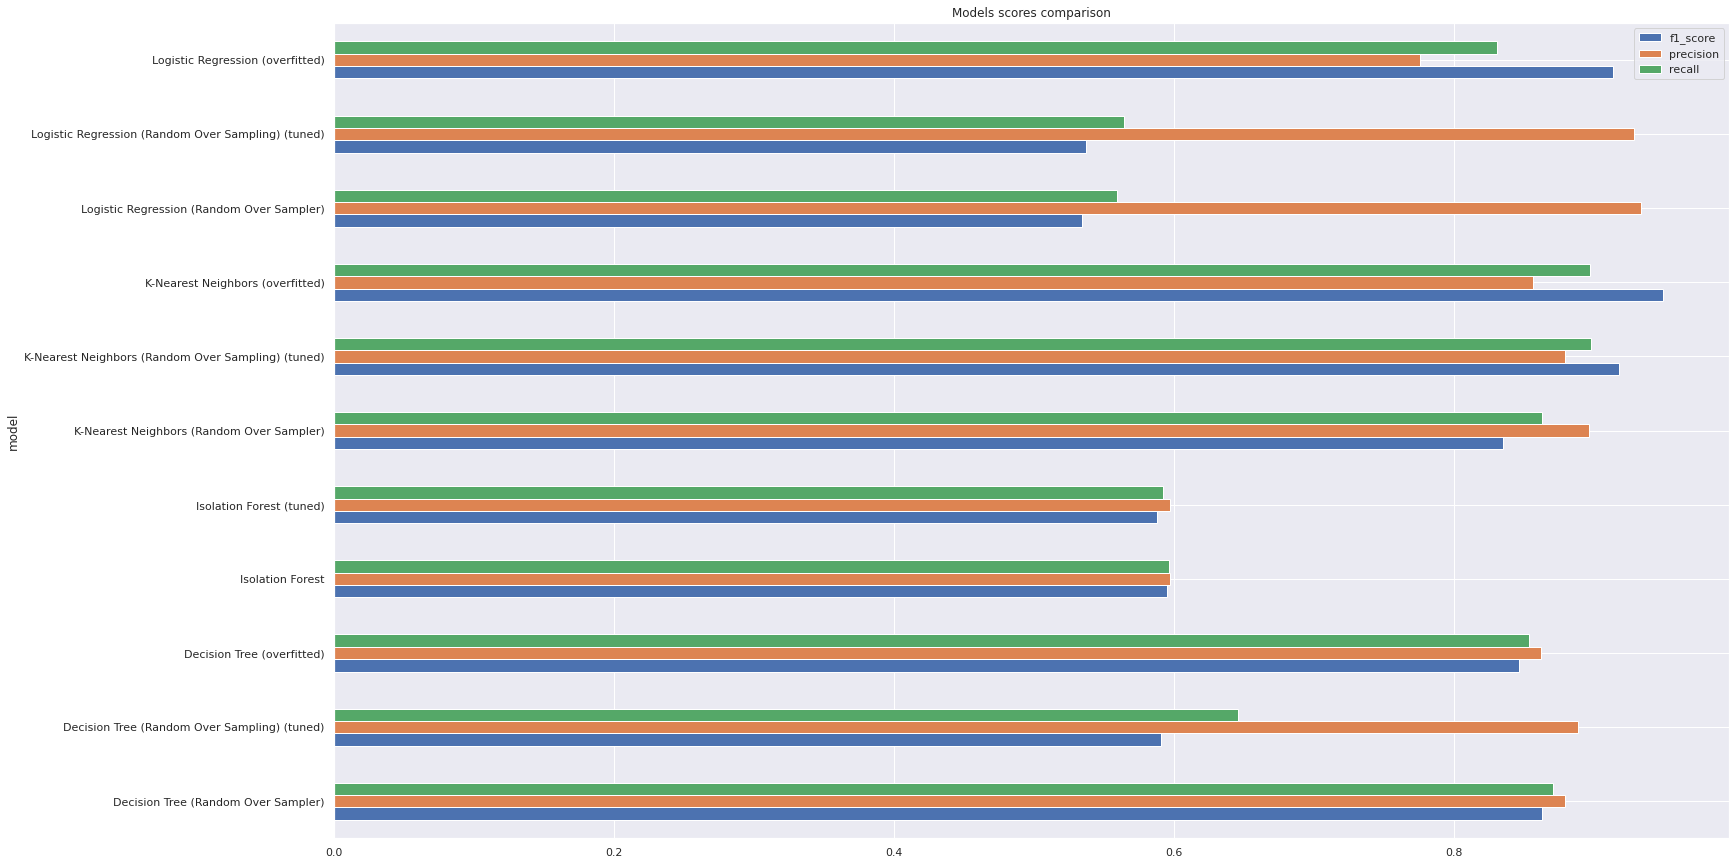

In [25]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(25, 15)
)

ax.set_title('Models scores comparison')
df_scores.sort_values(by=['model'], ascending=True).plot(kind='barh', x='model', ax=ax)

plt.show()

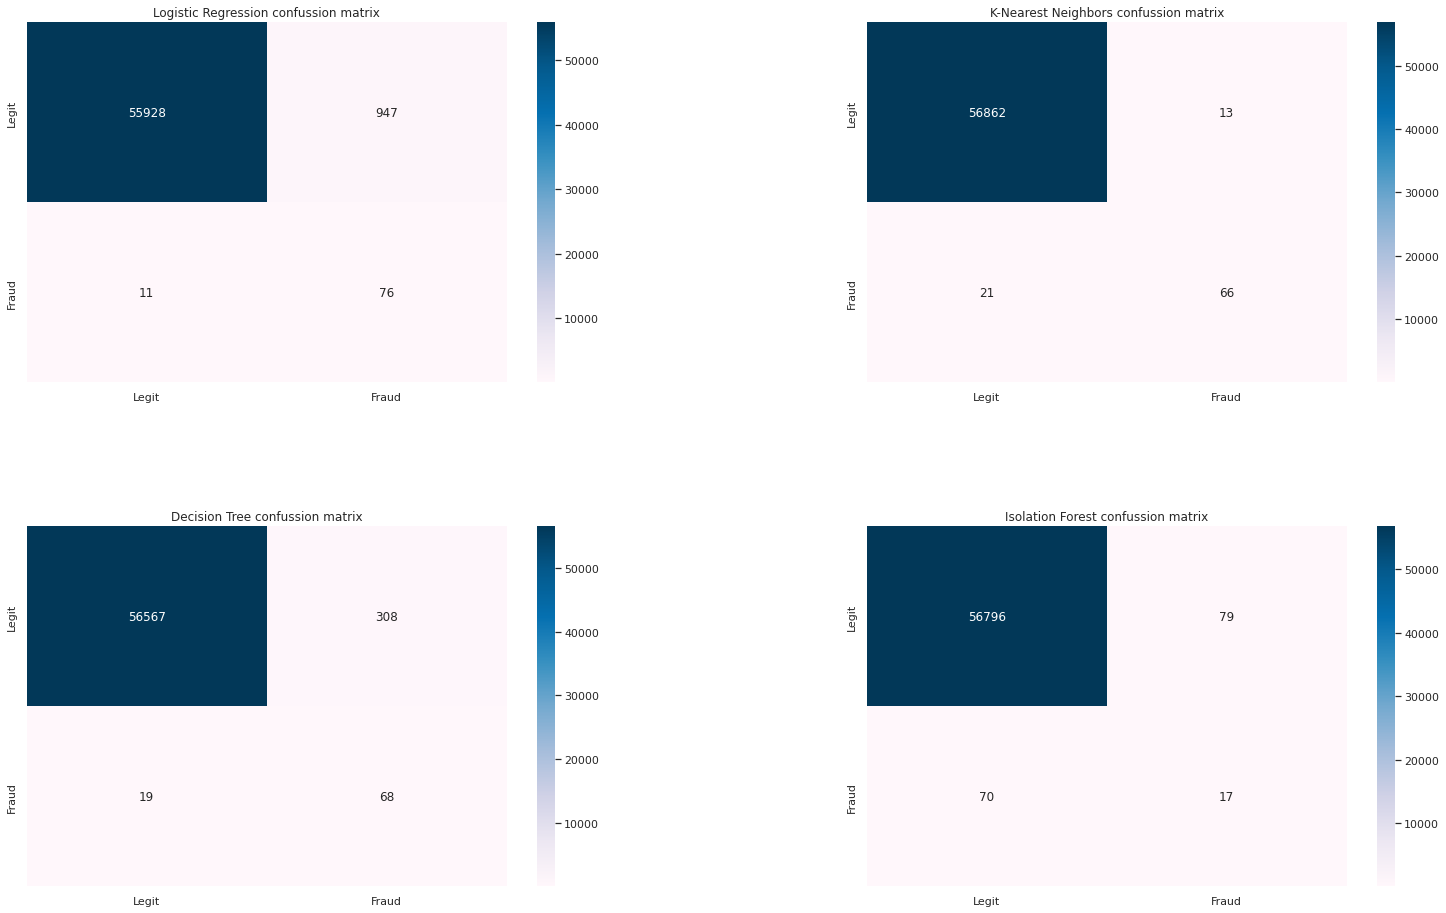

In [26]:

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(25, 15)
)

for model_name, values, ax in zip(
        best_grid_models.keys(),
        best_grid_models.values(),
        axes.flat
):
    _, model_preds = values
    ax.set_title(f'{model_name} confussion matrix')
    cf_matrix = confusion_matrix(y_test, model_preds)
    sns.heatmap(ax=ax, data=cf_matrix, annot=True, fmt='g', cmap='PuBu', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])

plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.4,
    hspace=0.4,
)
plt.show()


## 8. Persistencia de modelos <a class="anchor" id="chapter8"></a>

Una vez obtenidos los binaros de los modelos de este trabajo por último vamos a realizar un proceso de guardado disco para no tener que repetir todo el proceso cada vez que se necesite utilizar los modelos. Para este caso en particular guardaremos todos los modelos en la carpeta `models`.


In [27]:
OUTPUT_MODELS_PATH = os.path.join('.', 'models')
Path(OUTPUT_MODELS_PATH).mkdir(parents=True, exist_ok=True)

for model_name, values in best_grid_models.items():
    model, _ = values

    file_name = os.path.join(OUTPUT_MODELS_PATH, f"{model_name.replace(' ', '_').lower()}.joblib")
    print(f'Saving {model_name} as {file_name}...' )
    dump(model, file_name)

Saving Logistic Regression as ./models/logistic_regression.joblib...
Saving K-Nearest Neighbors as ./models/k-nearest_neighbors.joblib...
Saving Decision Tree as ./models/decision_tree.joblib...
Saving Isolation Forest as ./models/isolation_forest.joblib...



## 8.1 Tamaño en memoria <a class="anchor" id="section_8_1"></a>


In [28]:
OUTPUT_MODELS_PATH = os.path.join('.', 'models')

model_sizes = {
    'file': [],
    'Size (MB)': [],
}

for model_bin in os.listdir(OUTPUT_MODELS_PATH):
    bytes_size = Path(os.path.join(OUTPUT_MODELS_PATH, model_bin)).stat().st_size
    mb_size = round(bytes_size / (1024 * 1024), 3)

    model_sizes['file'].append(model_bin)
    model_sizes['Size (MB)'].append(mb_size)

HTML(pd.DataFrame(model_sizes).to_html(index=False))

file,Size (MB)
k-nearest_neighbors.joblib,111.057
isolation_forest.joblib,0.295
logistic_regression.joblib,3.473
decision_tree.joblib,3.485


## 8.2 Precisión <a class="anchor" id="section_8_2"></a>

En este apartado extraeremos la precisión de cada modelo para hacer para hacer comparativa con los resultados del apartado [7.3.3](#section_7_3_3).

In [29]:
model_accs = {
    'model': [],
    'acc (%)': []
}

for model_name, values in best_grid_models.items():
    model, preds = values
    acc = accuracy_score(y_test.values, preds)
    model_accs['model'].append(model_name)
    model_accs['acc (%)'].append(round(acc, 3) * 100)


HTML(pd.DataFrame(model_accs).to_html(index=False))

model,acc (%)
Logistic Regression,98.3
K-Nearest Neighbors,99.9
Decision Tree,99.4
Isolation Forest,99.7



Como se puede ver en la tabla anterior esta métrica por si sola no nos habría proporcionado la información del apartado [7.3.3](#section_7_3_3). Como conclusión final hemos comprobado que las decisiones tomadas en el apartado [2.4](#section_2_4) fueron correctas.



## 9. Interpretación de los resultados <a class="anchor" id="chapter9"></a>

Todos los modelos resultantes de este informe pueden ser descargados desde [este](https://drive.google.com/file/d/1embbUDoYAt52FJhCl2dyPCU6X8FuPcWF/view?usp=sharing) enlace. Analizando los resultados de los apartados [7.3.3](#section_7_3_3), [8.1](#section_8_1) [8.2](#section_8_2) se pueden plantear dos soluciones:

### 9.1 Logistic Regression + ROS <a class="anchor" id="section_9_1"></a>

* Con esta solución se maximizará la detección de verdaderos positivos, esto es, la cantidad de transacciones fraudulentas detectadas.
* Presenta una mayor tasa de falsos positivos pero tratándose de transacciones legítimas detectadas como fraudulentas no supone una pérdida de la calidad de detección.
* Este modelo tiene menor precisión pero como se explicó en el apartado [2.4](#section_2_4) no es una medida a tener en cuenta.
* Tiene un tiempo de entrenamiento relativamente pequeño en caso de que el juego de datos aumente. Mejor escalabilidad.
* El tamaño del modelo final tendrá menor peso en memoria facilitando su puesta en producción y coste de mantenimiento.
* **Como conclusión final:** esta solución es la recomendada dado que es la que más transacciones fraudulentas detecta.

### 9.2 K-Nearest Neighbors + ROS <a class="anchor" id="section_9_2"></a>

* Con esta solución se minimizar falsos positivos a costa de menos verdaderos positivos. La cantidad de transacciones fraudulentas detectadas será menor que la del apartado [9.1](#section_9-1).
* Presenta una menor tasa de falsos positivos por lo que hará que el sistema sea más rígido y tenga mayor precisión.
* Este modelo es el más preciso. Como se explicó en el apartado [2.4](#section_2_4) no es una medida a tener en cuenta.
* Tiene un tiempo de entrenamiento muy alto.
* El modelo final ocupa demasiado. En caso de tener juegos de datos grandes puede llegar a ocasionar problemas de escalabilidad.
* Su puesta en producción presenta mayor coste.
* **Como conclusión final:** es una solución válida si se desea tener un sistema muy preciso pero tiene el riesgo de detectar menos transacciones fraudulentas.

### 9.3 Resto de modelos <a class="anchor" id="section_9_3"></a>

* No han presentado unos buenos resultados  en el apartado [7.3.3](#section_7_3_3) como para tenerlos en cuenta en este informe. Aunque en la literatura este tipo de clasificadores han funcionado mejor para este caso de uso no han tenido la suficiente calidad como para considerarlos una solución válida.
* DecisionTree tiene un tiempo de entrenamiento y búsqueda de hiperparámetros muy alto.
* Isolation Forest tiene un tiempo de entrenamiento relativamente corto, no necesita preprocesado de datos y además genera un modelo que ocupa poco en memoria. Puede que en otro tipo de escenarios este algoritmo tenga una mejor relación de coste / eficiencia.
